In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 10] 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import skew, kurtosis
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

from utils import create_corr, display_metrics

par_3_to_remove = "The Links at Rolling Meadows Golf Club"

df = pd.read_csv("golf_18birdies_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df.head(3)

,timestamp,score,strokes,holeStrokes,stats_aces,stats_doubleEagleOrBetter,stats_eagles,stats_birdies,stats_pars,stats_bogeys,...,hole_10,hole_11,hole_12,hole_13,hole_14,hole_15,hole_16,hole_17,hole_18,date
0,2023-09-29 15:28:40.982,7,43,"[6, 6, 5, 4, 5, 4, 5, 4, 4]",0,0,0,0,3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29
1,2023-09-29 20:40:02.616,10,44,"[5, 5, 4, 5, 6, 5, 5, 5, 4]",0,0,0,0,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29
2,2023-09-30 02:09:34.052,22,93,"[7, 3, 6, 5, 5, 6, 4, 5, 8, 5, 6, 5, 6, 3, 6, ...",0,0,0,0,6,4,...,5.0,6.0,5.0,6.0,3.0,6.0,4.0,5.0,4.0,2023-09-30


In [2]:
df.columns

Index(['timestamp', 'score', 'strokes', 'holeStrokes', 'stats_aces',
       'stats_doubleEagleOrBetter', 'stats_eagles', 'stats_birdies',
       'stats_pars', 'stats_bogeys', 'stats_doubleBogeyOrWorse', 'name',
       'course_par', 'is_18_holes', 'hole_1', 'hole_2', 'hole_3', 'hole_4',
       'hole_5', 'hole_6', 'hole_7', 'hole_8', 'hole_9', 'hole_10', 'hole_11',
       'hole_12', 'hole_13', 'hole_14', 'hole_15', 'hole_16', 'hole_17',
       'hole_18', 'date'],
      dtype='object')

## What are some basic descriptive statistics of my 9 hole scores?


In [3]:
##9 holes
holes_9_df = df[df['is_18_holes'] == 0]
print(f"Length of the dataset with all scores {len(df)}")
print(f"Length of the dataset with just 9 hole scores {len(holes_9_df)}")
print("-----------------------")

##Mean and median score, But need to get rid of par 3 scores
print(f"Mean Score (before removing par 3 couese scores): {holes_9_df['strokes'].mean()}")
print(f"Median Score (before removing par 3 couese scores): {holes_9_df['strokes'].median()}")
print("-----------------------")

##Getting rid of par 3 scores (Just from one course so I can remove it by name)
rows_to_remove = holes_9_df['name'] == par_3_to_remove
removed_count = rows_to_remove.sum()
holes_9_df_cleaned = holes_9_df[~rows_to_remove]

##Mean and median score, with par 3 scores removed
print(f"Mean Score (after removing par 3 couese scores): {holes_9_df_cleaned['strokes'].mean()}")
print(f"Median Score (after removing par 3 couese scores): {holes_9_df_cleaned['strokes'].median()}")

print(holes_9_df_cleaned['strokes'].describe())

Length of the dataset with all scores 42
Length of the dataset with just 9 hole scores 28
-----------------------
Mean Score (before removing par 3 couese scores): 47.285714285714285
Median Score (before removing par 3 couese scores): 47.0
-----------------------
Mean Score (after removing par 3 couese scores): 48.68
Median Score (after removing par 3 couese scores): 47.0
count    25.000000
mean     48.680000
std       4.038564
min      43.000000
25%      47.000000
50%      47.000000
75%      52.000000
max      58.000000
Name: strokes, dtype: float64


In [20]:
print("Average # of Birdies per round",holes_9_df_cleaned['stats_birdies'].mean())
print("Average # of Par per round",holes_9_df_cleaned['stats_pars'].mean())
print("Average # of Bogeys per round",holes_9_df_cleaned['stats_bogeys'].mean())
print("Average # of Double Bogeys or more per round",holes_9_df_cleaned['stats_doubleBogeyOrWorse'].mean())

Average # of Birdies per round 0.12
Average # of Par per round 1.24
Average # of Bogeys per round 3.76
Average # of Double Bogeys or more per round 3.88


In [16]:
holes_9_df_cleaned['bins'] = pd.cut(holes_9_df_cleaned['strokes'], bins=6)
print(holes_9_df_cleaned['bins'].value_counts())

stats = holes_9_df_cleaned.groupby('bins')[['stats_birdies', 'stats_pars']].describe()
print(stats)

stats2 = holes_9_df_cleaned.groupby('bins')[['stats_bogeys', 'stats_doubleBogeyOrWorse']].describe()
print(stats2)


(45.5, 48.0]      11
(42.985, 45.5]     5
(50.5, 53.0]       4
(53.0, 55.5]       3
(55.5, 58.0]       1
(48.0, 50.5]       1
Name: bins, dtype: int64
               stats_birdies                                               \
                       count      mean       std  min  25%  50%  75%  max   
bins                                                                        
(42.985, 45.5]           5.0  0.200000  0.447214  0.0  0.0  0.0  0.0  1.0   
(45.5, 48.0]            11.0  0.181818  0.404520  0.0  0.0  0.0  0.0  1.0   
(48.0, 50.5]             1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   
(50.5, 53.0]             4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
(53.0, 55.5]             3.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
(55.5, 58.0]             1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0   

               stats_pars                                               
                    count      mean       std  min  25%  50%  75%  max  
bins     

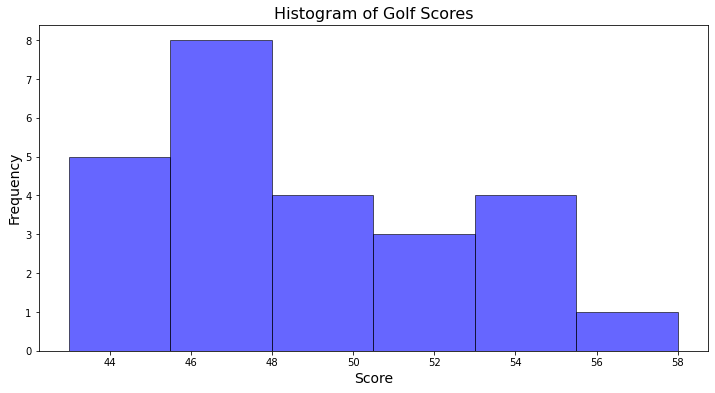

In [68]:
plt.figure(figsize=(12, 6))  # Set the figure size (width=12, height=6 in inches)

plt.hist(holes_9_df_cleaned['strokes'], bins=6, color='blue', edgecolor='black', alpha=0.6)

# Add titles and labels
plt.title('Histogram of Golf Scores', fontsize=16)  # Increase title font size for better visibility
plt.xlabel('Score', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Frequency', fontsize=14)  # Increase y-axis label font size

# Display the plot
plt.show()

### Do I score better at certain courses? - Yes

In [69]:
holes_9_df_cleaned.groupby(['name']).agg({'strokes':['mean','median']}).sort_values(('strokes', 'mean'))

strokes       
                                                   mean median
name                                                          
Indian Trails Golf Course                     43.000000   43.0
Rolling Meadows Golf Course                   45.000000   45.0
Terra Verde Golf Course                       46.000000   46.0
Downing Farms Golf Course                     47.000000   47.0
Huron Meadows Metropark Golf Course           47.000000   47.0
Maple Hill Golf                               47.666667   47.0
Wallinwood Springs                            47.666667   47.0
Yankee Springs Golf Course                    47.750000   47.5
Brae Burn Golf Club                           48.000000   48.0
The Pines Golf Course                         48.000000   48.0
Ironwood Golf Course                          49.500000   49.5
Kaufman Golf Course at Palmer Park            52.400000   52.0
The Meadows at Grand Valley State University  55.000000   55.0

## Distrubution of the scores

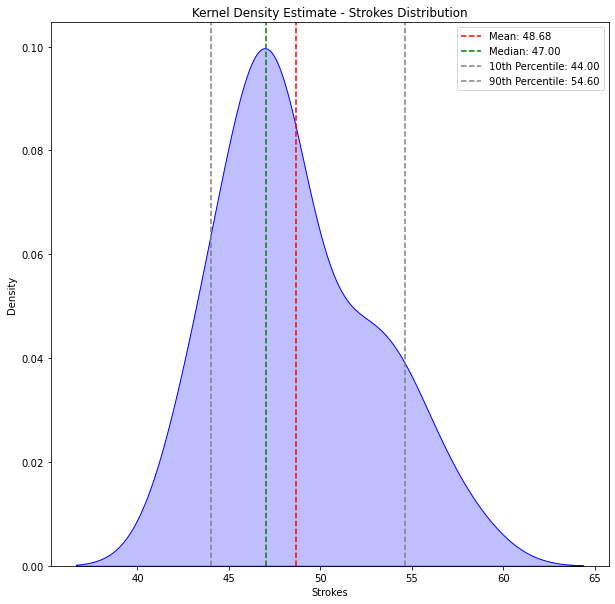

In [70]:
data = holes_9_df_cleaned['strokes']
bott_pctile = 10
top_pctile = 90

# Calculate statistics
mean = np.mean(data)
median = np.median(data)
percentile_bott = np.percentile(data, bott_pctile)
percentile_top = np.percentile(data, top_pctile) 

# Create KDE plot
sns.kdeplot(data, shade=True, color='blue')
plt.title('Kernel Density Estimate - Strokes Distribution')
plt.xlabel('Strokes')
plt.ylabel('Density')

# Overlay statistics
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(percentile_bott, color='gray', linestyle='--', label=f'{bott_pctile}th Percentile: {percentile_bott:.2f}')
plt.axvline(percentile_top, color='gray', linestyle='--', label=f'{top_pctile}th Percentile: {percentile_top:.2f}')

# Add legend
plt.legend()
plt.show()

Skewness: 0.6175943342065684
Kurtosis: -0.47272646279680064


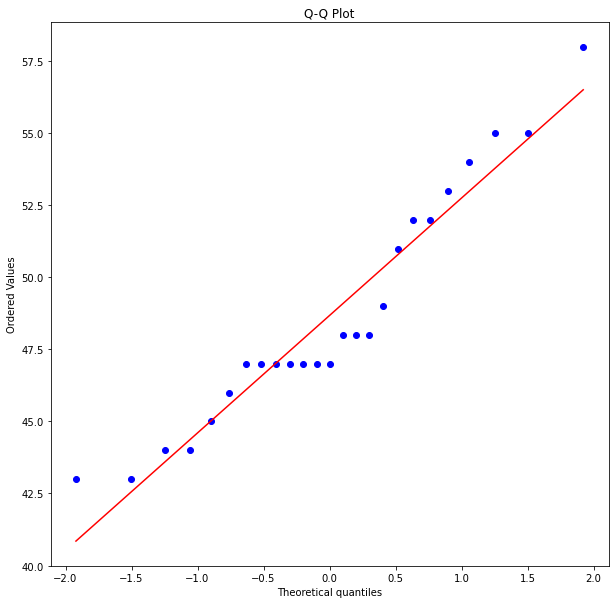

In [71]:
print("Skewness:", skew(holes_9_df_cleaned['strokes']))
print("Kurtosis:", kurtosis(holes_9_df_cleaned['strokes']))

data = holes_9_df_cleaned['strokes']
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

## Relationship analysis (Correlation)

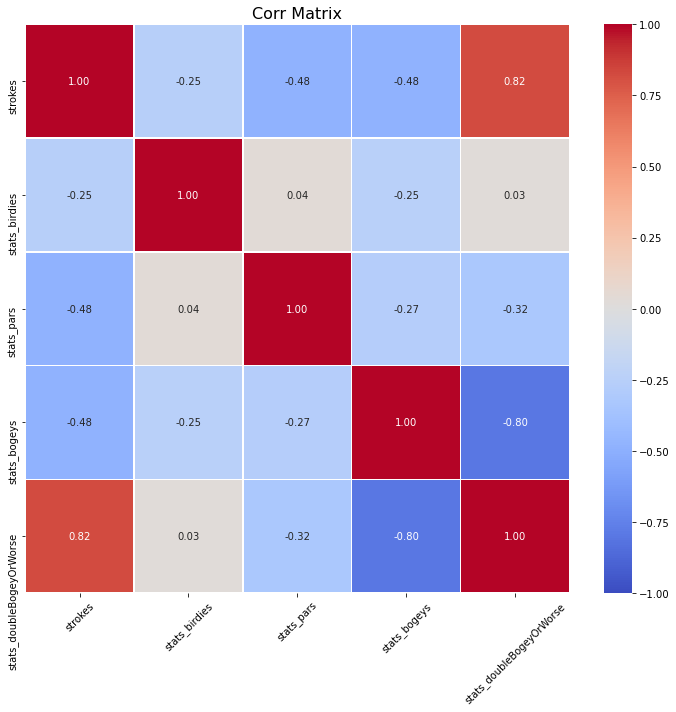

In [72]:
##Going to create correlation matrix --- Correlation between strokes and various scores
holes_9_df_cleaned_small = holes_9_df_cleaned[['strokes', 'stats_birdies', 'stats_pars', 'stats_bogeys', 'stats_doubleBogeyOrWorse']].copy()
create_corr(holes_9_df_cleaned_small)

##As strokes goes up (strong postive) so does double bogeys.... more double bogeys.... more score

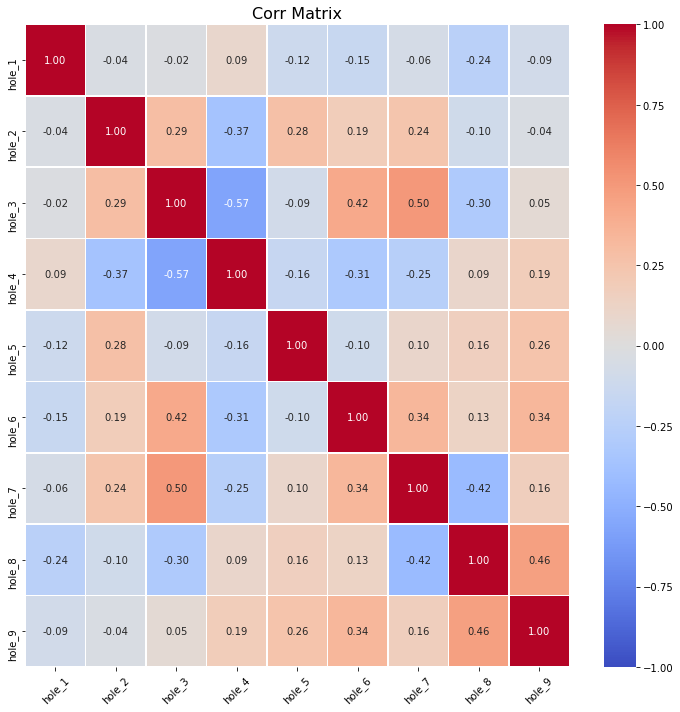

In [73]:
##Do bad holes lead to more bad holes.... correlation of score to the next hole...?
holes_9_df_cleaned_small2 = holes_9_df_cleaned[['hole_1', 'hole_2', 'hole_3', 'hole_4', 'hole_5', 'hole_6', 'hole_7',
       'hole_8', 'hole_9']].copy()

create_corr(holes_9_df_cleaned_small2)

## Score over TIME analysis

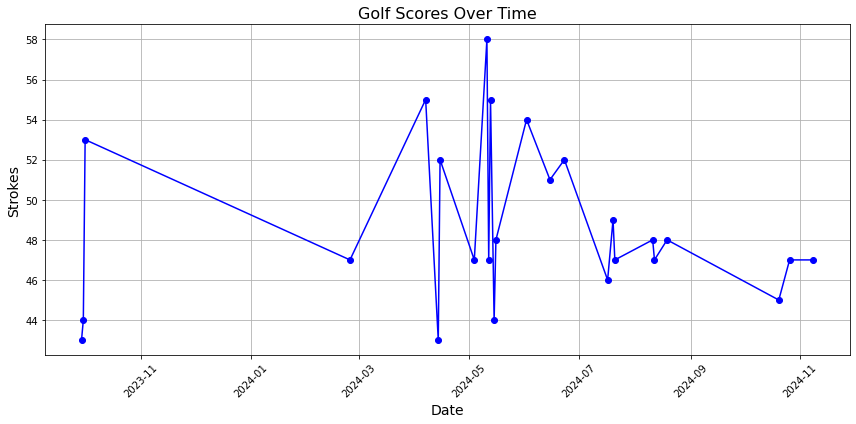

In [74]:
holes_9_df_cleaned['date'] = pd.to_datetime(holes_9_df_cleaned['date'])
holes_9_df_cleaned = holes_9_df_cleaned.sort_values(by='date')
holes_9_df_cleaned = holes_9_df_cleaned.reset_index()

##Loop goes through the dataset and adds a day to a duplicated value.... this is to try and make
##the line plot more continous
for i in range(0, len(holes_9_df_cleaned)):
    if holes_9_df_cleaned['date'].iloc[i] == holes_9_df_cleaned['date'].iloc[i - 1]:
        holes_9_df_cleaned.at[i, 'date'] += pd.Timedelta(days=1)

plt.figure(figsize=(12, 6))
plt.plot(holes_9_df_cleaned['date'], holes_9_df_cleaned['strokes'], marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Golf Scores Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Strokes', fontsize=14)

# Rotate x-axis labels to make them readable if necessary
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Equation of the line: y = -0.0538x + 49.3262
R-squared (R²): 0.0096
Mean Squared Error (MSE): 15.5068
Mean Absolute Error (MAE): 3.1886
Root Mean Squared Error (RMSE): 3.9379


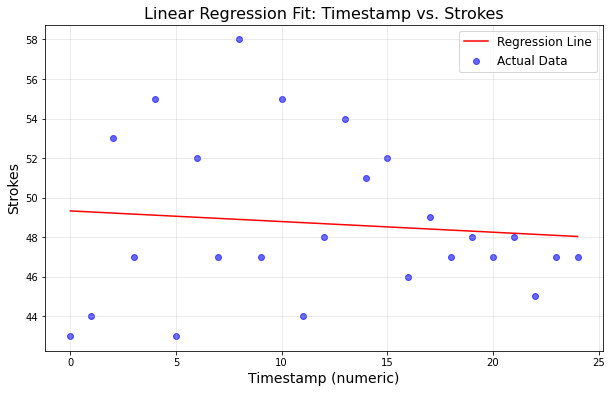

In [75]:
holes_9_df_cleaned['date'] = pd.to_datetime(holes_9_df_cleaned['date'])
holes_9_df_cleaned = holes_9_df_cleaned.sort_values(by='date')

holes_9_df_cleaned_linear = holes_9_df_cleaned[['timestamp', 'strokes']].copy()
holes_9_df_cleaned_linear['time'] = holes_9_df_cleaned_linear.index


y = holes_9_df_cleaned_linear[['strokes']]
X= holes_9_df_cleaned_linear[['time']]

regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

# Extract scalar values for slope and intercept
intercept = regressor.intercept_
slope = regressor.coef_[0]  # Extract the first (and only) element of the array


display_metrics(slope,intercept,y,y_pred)

# Plot the data and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data', alpha=0.6)
plt.plot(X, y_pred, color='red', label='Regression Line')
plt.xlabel('Timestamp (numeric)', fontsize=14)
plt.ylabel('Strokes', fontsize=14)
plt.title('Linear Regression Fit: Timestamp vs. Strokes', fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## So each round I am getting .05 strokes better.... started at a 49.3 based on the equation of the line

## Outlier Detection

In [77]:
##starting off simple with IQR   ---> no points are deemed outliers
# Calculate Q1, Q3, and IQR
Q1 = holes_9_df_cleaned['strokes'].quantile(0.25)
Q3 = holes_9_df_cleaned['strokes'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
holes_9_df_cleaned['is_outlier'] = (holes_9_df_cleaned['strokes'] < lower_bound) | (holes_9_df_cleaned['strokes'] > upper_bound)

holes_9_df_cleaned['is_outlier'].value_counts()


False    25
Name: is_outlier, dtype: int64

In [88]:
##-1 here indicate outliers..... none are displayed so that means all scores are okay

from sklearn.ensemble import IsolationForest
model = IsolationForest(n_estimators=10, contamination="auto")
model.fit([holes_9_df_cleaned['strokes']]) 
y_pred = model.predict([holes_9_df_cleaned['strokes']])
y_pred

array([1])

In [92]:
holes_9_df_cleaned.head(3)

,index,timestamp,score,strokes,holeStrokes,stats_aces,stats_doubleEagleOrBetter,stats_eagles,stats_birdies,stats_pars,...,hole_11,hole_12,hole_13,hole_14,hole_15,hole_16,hole_17,hole_18,date,is_outlier
0,0,2023-09-29 15:28:40.982,7,43,"[6, 6, 5, 4, 5, 4, 5, 4, 4]",0,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-29,False
1,1,2023-09-29 20:40:02.616,10,44,"[5, 5, 4, 5, 6, 5, 5, 5, 4]",0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-30,False
2,3,2023-10-01 16:36:45.472,17,53,"[5, 6, 7, 4, 7, 6, 6, 6, 6]",0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-10-01,False
